Support Vector Machines: what do features in the implicit space mean?
===

**Abstract** I think a lot of SVM tutorials give all the details about the maximum margin separating hyperplane, the quadratic programming and support vectors, and radial kernels, but don't give a good intuition on one important part of the big picture. When the kernel does its implicit mapping from the original feature space to a new feature space, what does that new feature space look like? What do the features in that new space mean? This short notebook tries to fill in the missing link.

Introduction
---

SVMs implicitly create a new feature space and then carry out linear classification in that. [Cover's theorem](https://en.wikipedia.org/wiki/Cover%27s_theorem) explains why the data are more likely to be linearly separable in the new feature space if it's higher-dimensional. A common illustration of the main idea is a dataset where one class is enclosed in the unit circle: that's not linearly separable. But if the implicit mapping does something like this: $$(x_0, x_1) \rightarrow (x_0, x_1, \sqrt{x_0^2 + x_1^2})$$ (ie add a new feature equal to the distance of the point from the origin), the data will be separable by that feature alone. This diagram (from [hackerearth.com](https://www.hackerearth.com)) illustrates the idea (note, here the data is in an ellipse not centered at the origin, so the new feature is not using the exact equation above, but the idea is the same): ![Cover and separation](https://www.hackerearth.com/blog/wp-content/uploads/2017/02/kernel.png)

But while this illustrates the potential benefit of a higher-dimensional space, it is a bit misleading for two reasons. First, it suggests that the new space consists of the old space plus some additional features, and that's not the case. In reality the new space will have all-new features, none of the old ones. Second, the new feature in this example is not quite the type of feature that SVMs actually create! They don't create features by manipulation/combination of existing features. What features *do* they create?

Looking at training data
---

In [1]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.svm import SVC
%matplotlib inline

Suppose our training data $X$ is in two dimensions and consists of four points with labels -1 (blue) and +1 (red).

In [2]:
X = np.array([[0.5, 0.1], [0.4, 0.4], [0.6, 0.6], [0.7, 0.8]])
y = np.array([-1, -1, 1, 1])
y_pos = (y == 1)
y_neg = (y == -1)

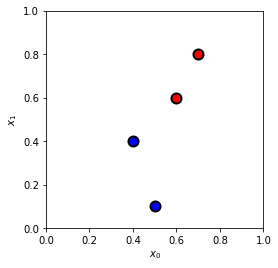

In [3]:
plt.plot(X[y_neg, 0], X[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(X[y_pos, 0], X[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.axes().set_aspect('equal')

The goal of the SVM is to classify new unknown points, such as the point $q$ indicated by the green square here.

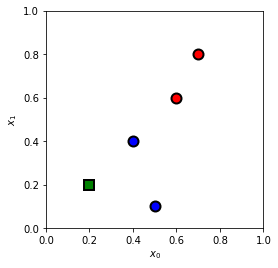

In [4]:
q = np.array([0.2, 0.2])
plt.plot(X[y_neg, 0], X[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(X[y_pos, 0], X[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.plot(q[0], q[1], 's', c='g', markersize=10, mew=2, mec='k')
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.axes().set_aspect('equal')

Kernels
---

We'll use a Gaussian kernel $K_h$ with bandwidth $h$.

In [5]:
def d(x, y):
    return np.linalg.norm(x - y) # Euclidean distance

h = 0.5
def K(x, y):
    return np.exp(- d(x, y)**2.0 / (2 * h**2.0))

That means that the value of $K_h(x, y)$ is the value of a 1-dimensional Gaussian centered at $0$ with $\sigma^2=h$, evaluated at the point $|x-y|$, that is the point on the axis which is $|x-y|$ in distance from the centre of the Gaussian. 

A kernel is a *measure of similarity*, so $K$ will be large when $x$ and $y$ are close together.

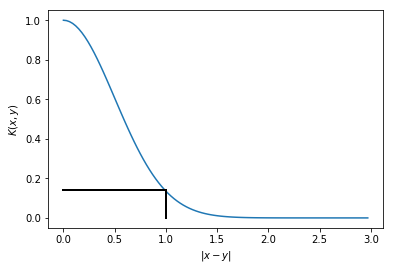

In [6]:
grid = np.linspace(0, 1, 100)
x0 = np.array([0.4, 0.4])
y0 = np.array([2.5, 2.5])
K_vals = [K(x0, x0+(y0-x0)*gi) for gi in grid]
d_vals = [d(x0, x0+(y0-x0)*gi) for gi in grid]
plt.plot(d_vals, K_vals)
plt.plot((0, d(x0, (1.1, 1.1))), (K(x0, (1.1, 1.1)), K(x0, (1.1, 1.1))), color='k', linestyle='-', linewidth=2)
plt.plot((1, 1)                , (0                , K(x0, (1.1, 1.1))), color='k', linestyle='-', linewidth=2)
plt.plot(())
plt.xlabel(r"$|x-y|$")
plt.ylabel(r"$K(x, y)$");

In the diagram above, we have plotted the value of $K$ as distance increases. We have two points $x'$ and $y'$: think of $x'$ as being at 0.0 on the horizontal axis, and as the point $y$ moves from $x'$ to $y'$, we move along the horizontal axis, and $K$ drops. For example, when $y=(1.1, 1.1)$, we have: $$|x - y| = d(x, y) = 1.0$$
so we look at 1.0 on the horizontal axis, and see that $K(x, y)$ has a value near 0.14.

Training and the implicit mapping to a new space
---

Let's train our SVM. We'll talk about the training procedure shortly, but for now go straight to looking at the result. With the right choice of parameters, we'll get exactly two support vectors, that is two of our training points become support vectors. They'll be the points which are closest to the boundary between classes: the two points $(0.4, 0.4), (0.6, 0.6)$ -- one labelled -1, the other +1. We can also print the weights and bias, and we'll come back to those.

In [7]:
svc = SVC(kernel='rbf', gamma=1 / (2 * h**2), C=10)
svc.fit(X, y)
SVs = svc.support_vectors_
w = svc.dual_coef_[0]
b = svc.intercept_
print(SVs)
print(w)
print(b)

[[ 0.4  0.4]
 [ 0.6  0.6]]
[-6.76332653  6.76332653]
[-0.]


Our original training data maps to the new space as follows. For each point in the training data, and each support vector, we calculate $K$ between the training point and the SV, and that gives one feature $z_i$ for that training point. 

In [8]:
def z(q, SVs):
    return np.array([K(q, xi) for xi in SVs])

In [9]:
Z = np.array([z(xi, SVs) for xi in X])
Z

array([[ 0.81873075,  0.59452055],
       [ 1.        ,  0.85214379],
       [ 0.85214379,  1.        ],
       [ 0.60653066,  0.90483742]])

Note the value 1.0, which occurs when evaluating $K(x, x)$, ie the similarity between a point and itself. It's the largest possible similarity.

We can also do the same for our query point $q$ whose label is unknown.

In [10]:
qz = z(q, SVs)
qz

array([ 0.85214379,  0.52729242])

Here, the value approximately 0.85 is a measure of similarity between the green query point and the first SV, that is the upper blue point.

Now let's look at the implicit new space. In our example, it is of two dimensions, the same as the original space, but that isn't usually the case! The number of dimensions in the new space is equal to the number of SVs. (The reason we made sure to have just two SVs is so that the new implicit feature space could be plotted easily.) The training data and query points are plotted in the new space below.

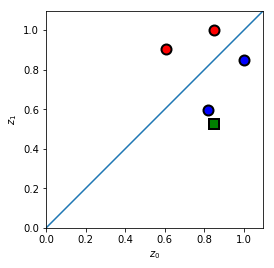

In [11]:
plt.plot(Z[y_neg, 0], Z[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(Z[y_pos, 0], Z[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.plot(qz[0], qz[1], 's', c='g', markersize=10, mew=2, mec='k')
plt.plot((0, 1.1), (0, 1.1))
plt.xlabel(r"$z_0$")
plt.ylabel(r"$z_1$")
plt.xlim((0, 1.1))
plt.ylim((0, 1.1))
plt.axes().set_aspect('equal')

Prediction and the maximum-margin separating hyperplane
---

We have plotted the maximum-margin separating hyperplane also. This is the line which gives the greatest possible margin between support vectors in the implicit space. It's easy to see that in this case it should be a 45-degree line bisecting the two SVs. We see that the query point ends up on the "blue" side of it as it should. The hyperplane is indeed a hyperplane here, ie a line and not a curve, because the SVM is a linear classifier in the new implicit space. It may be non-linear when we view the decision function in the original space.

We can *see* the decision for the query point by seeing which side of the line it falls on. But how do we actually calculate the decision? We have a weight $w_i$ for each SV, and a bias $b$, given by the training. The *decision function* is: if $$b + \sum_i w_i K(q, x_i) > 0$$ the output is +1, else -1 (where $x_i$ are the SVs).

The line is determined by $w$ and $b$. In fact, the line is the set of points where the decision function is 0: $$b + \sum_i w_i K(q, x_i) = 0$$ (where $x_i$ are the SVs). 

It's interesting to look at the left-hand side of the decision function, so we'll bring that out as its own function.

In [12]:
def decision_function(q, SVs):
    wx = b + np.sum(w[i] * K(q, SVs[i]) for i in range(len(SVs)))
    return wx

def predict(q, SVs):
    if decision_function(q, SVs) > 0: return +1
    else                            : return -1

For example, the decision function for $q$ is negative:

In [13]:
decision_function(q, SVs)

array([-2.19707585])

In [14]:
predict(q, SVs)

-1

Now, we might have noticed an interesting property of the weights $w$ when we printed them out. The weight $w_i$ was negative for an SV labelled -1, and positive for an SV labelled +1. That means that similarity to the first SV should give a *negative* contribution to the decision function, leading to a -1 outcome; similarity to the second SV should give a *positive* contribution, leading to a +1 outcome. (Things could be more complicated when some SVs are on the wrong side of the hyperplane because the data is not linearly separable in the implicit space, ie when we need a soft margin: but we'll ignore that.)

We can rewrite the decision function as: if $$b + \sum_{i: y_i=+1} w_i K(q, x_i) > \sum_{i: y_i=-1} -w_i K(q, x_i)$$ (where $x_i$ are the SVs) then +1, else -1. Because of the negative/positive property of the weights mentioned above, the $w_i$ on the right-hand side are negative, so $-w_i$ on the right-hand side are positive. So (ignoring the bias): if the query point is more similar (in weighted average) to the SVs with label +1 than to the SVs with label -1, then the output is +1 (and vice versa).

Now we can talk about what the SVM training procedure is trying to do. It's trying to maximise the margin of the separating hyperplane (an objective function), *subject to* putting each SV on the correct side of that hyperplane (a set of constraints). It uses quadratic programming to achieve this. The separating hyperplane (decision boundary) is the set of points where the two expressions above are *equal*: $$b + \sum_{i: y_i=+1} w_i K(q, x_i) = \sum_{i: y_i=-1} -w_i K(q, x_i)$$ $$b + \sum_{i: y_i=+1} w_i z_i = \sum_{i: y_i=-1} -w_i z_i$$ The SVM chooses the two closest-together opposite-labelled points as the SVs and gives them equal weights $w=(-6.76, 6.76)$. It also chose $b=0$. The equation of the hyperplane in the new space is then just $6.76z_1 = -(-6.76)z_0$, ie $z_1=z_0$, hence the 45-degree straight line. Of all possible lines, it is the one which gives the largest possible margin between each SV and the line.

The effect of the decision boundary in the original space
---

Now, we can plot the decision function over the original space, and superimpose the training data and the query point. We'll see a decision boundary (white line), and as we move away from the decision boundary, the decision becomes more and more "certain".

In [15]:
g = 101
grid = np.linspace(0, 1, g)
im = np.zeros((g, g))
for i in range(g):
    for j in range(g):
        im[i, j] = decision_function((grid[i], grid[j]), SVs)

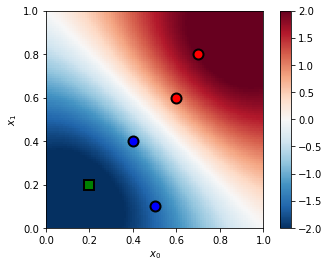

In [16]:
plt.pcolor(grid, grid, im.T, cmap='RdBu_r', vmin=-2, vmax=+2)
plt.colorbar()
plt.plot(X[y_neg, 0], X[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(X[y_pos, 0], X[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.plot(q[0], q[1], 's', c='g', markersize=10, mew=2, mec='k')
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.axes().set_aspect('equal')

Hey, why isn't the decision boundary non-linear as promised? We can see non-linear behaviour of the decision *function* plotted above, but the boundary looks to be linear. That happens because we only have two SVs. 

So let's add in another training point in such a position that it will become a third SV, and see what effect that will have on the decision value and boundary in the original space. (We won't be able to plot it in the new space as well, since it will now have 3 dimensions.)

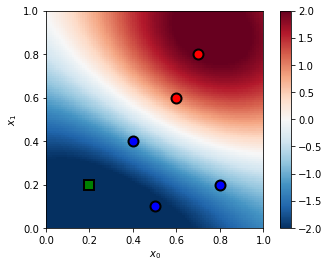

In [17]:
X = np.array([[0.5, 0.1], [0.8, 0.2], [0.4, 0.4], [0.6, 0.6], [0.7, 0.8]])
y = np.array([-1, -1, -1, 1, 1])
y_pos = (y == 1)
y_neg = (y == -1)

svc = SVC(kernel='rbf', gamma=1 / (2 * h**2), C=10)
svc.fit(X, y)
SVs = svc.support_vectors_
w = svc.dual_coef_[0]
b = svc.intercept_

for i in range(g):
    for j in range(g):
        im[i, j] = decision_function((grid[i], grid[j]), SVs)

plt.pcolor(grid, grid, im.T, cmap='RdBu_r', vmin=-2, vmax=+2)
plt.colorbar()

plt.plot(X[y_neg, 0], X[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(X[y_pos, 0], X[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.plot(q[0], q[1], 's', c='g', markersize=10, mew=2, mec='k')
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.axes().set_aspect('equal')

With the three SVs, we now have a non-linear boundary.

It's interesting to see that the weights still sum to 0: two smaller negative weights for the two SVs labelled -1, and one larger positive weight for the SV labelled +1. The bias is now non-zero also.

In [18]:
print(w)
print(b)

[-1.70835027 -5.90998055  7.61833082]
[-0.43687287]


Let's check the numerical values of the prediction for point $q$:

In [19]:
svc.predict([q])

array([-1])

In [20]:
svc.decision_function([q])

array([-2.28748131])

In [21]:
predict(q, SVs)

-1

In [22]:
decision_function(q, SVs)

array([-2.28748131])

We see that our values are matching those from the `sklearn` SVM (phew), and the prediction for $q$ is negative as it should be.

Is the example misleading?
---

Now that we understand the nature of the features created implicitly by the SVM, let's revisit the example at the top of the notebook, where one class of data is enclosed by a hypersphere in the original space. Can the SVM create a feature which directly represents "distance from the centre"? Well, nearly. Consider the unit circle in 2 dimensions. Let's suppose there is an SV *at the origin*. Then with a Gaussian kernel, one of the new features will be the *similarity to the origin*, that is a transformation of distance from the origin, which is just $\sqrt{x_0^2 + x_1^2}$, just as in the example. More realistically, if the centre of the circle is $c=(c_0, c_1)$ (and one SV is at $c$) rather than at the origin, the formula becomes $\sqrt{(x_0 - c_0)^2 + (x_1 - c_1)^2}$. It's important to think of this new feature as a distance from an SV, not as a transformation of the existing features. But still, it would nicely separate the data inside the circle from that outside. 

But the problem is that *there would never be an SV at the centre*! SVs occur near the decision boundary. So the common example is definitely slightly misleading.

Conclusion
---

So, an SVM can be seen as an algorithm which decides the label of a query point by testing whether it is more similar in weighted average to a subset (the SVs) of the +1 examples, or to a subset (the SVs) of the -1 examples. Similarity is measured by the kernel, based ultimately on an inverse mapping of Euclidean distance. In this sense, an SVM is closely related to techniques such as $k$ nearest neighbours, kernel density classification, and dissimilarity representations (eg Duin & Pekalska, Pattern Recognition Letters 33 (2012) 826–832). 

In particular, we could make a crude proto-SVM by just calculating the mean of distances (in the original space) from $q$ to all the +1 points, and to all the -1 points, and finding out which is larger! This would leave out the kernel and the choice of SVs, but otherwise would be quite similar to an SVM. We could call it a mean-distance classifier. The computational complexity at query time would scale linearly with the size of the training data, which is a disadvantage relative to an SVM. If we used a kernel instead of just raw distance, it would become a kernel density classifier, with the same computational complexity disadvantage. Since similarity measured by a Gaussian kernel goes exponentially towards 0, this would give less emphasis to distant points than the mean-distance clasifier, hence would be a bit more robust to outlier points. If we go on to chose a subset of points to be the "prototypes" (the term used in the dissimilarity representation literature), instead of using all training data, the complexity would improve, and with a careful choice of these prototypes the generalisation would actually get better. The final refinement would be to define soft constraints that each labelled point must be on the correct side of the hyperplane, and an objective function which maximises the margin, and optimise using quadratic programming. This would make a careful choice of prototypes (now called SVs) and weights $w$ -- and then it is an SVM again.

**Acknowledgements** Thanks to Stefano Mauceri and Loi Van Cao for useful discussions on these topics and to Sean McGarraghy for excellent notes in the UCD MIS40530 module.